In [1]:
import pandas as pd
import numpy as np
import re #used as a regular expression to find particular patterns and process it
import string #used to obtain information in the string and manipulate the string overall
import warnings
from wordcloud import WordCloud
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk #a natural language processing toolkit module associated in anaconda
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
DATASET_COLUMNS=['target','ids','date','query','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('dataset1.csv', \
                 encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.tail(5)

,target,ids,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [3]:
np.sum(df.isnull().any(axis=1))

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df['target'] = df['target'].replace(4,1)


Negative    800000
Positive    800000
Name: target, dtype: int64


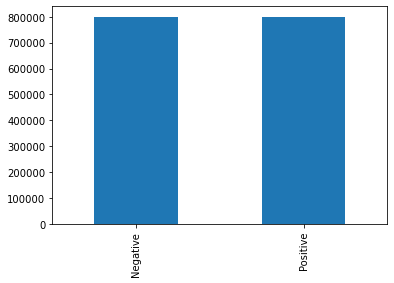

In [6]:
# Visualising

sentiment = {0:"Negative", 1:"Positive"}
print(df.target.apply(lambda x: sentiment[x]).value_counts())
df.target.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

In [7]:
# Considering only target and text

data=df[['text','target']]
data.head(2)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0


In [8]:
# can use entire dataset for this Analysis or select a subset of 1.6 Million tweets. 
# In this using 50k entires. 
# in the process of sampling maintaining the correct target ratio is very imp.

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

dataset = pd.concat([data_pos, data_neg])

print(len(dataset))
dataset.head(2)

40000


,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1


In [9]:
# Converting to Lower case

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [10]:
# Defining stopwords

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [11]:
# Removing Stopwords

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

19995    not much time off weekend, work trip malmï¿½ f...
19996                                     one day holidays
19997                   feeling right .. hate damn humprey
19998    geez,i hv read whole book personality types em...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [12]:
# Removing stop words using nltk lib

#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

NLTK stop word lists 

{"you've", 'yours', 'as', 'now', 'doing', 'between', 'isn', 'if', 'y', 'the', 'd', 'any', 'are', 'but', 'no', 'whom', "should've", "mustn't", 'only', 'was', 'own', 'hers', 'how', 'mightn', 'won', 'which', 'against', 'had', 'wasn', 'about', 'more', 'ourselves', 'in', 'ain', 'they', 'does', 'or', 'shan', 'weren', "didn't", 've', 'being', 'he', 'these', 'her', 'your', "hasn't", 'can', 'for', "won't", 'himself', "couldn't", 'myself', 'just', 'why', 'ours', 'once', 'most', 'such', 'through', 'so', 'into', 'where', 'all', 'yourselves', 'is', 'above', "wasn't", 'we', 'were', 'and', 'doesn', 'under', 'his', 'those', 'down', "wouldn't", 'should', 'until', 'couldn', 'here', "haven't", 'have', 'of', 'mustn', 'yourself', 'it', "you're", 'same', 'shouldn', 'on', 'hasn', 'few', 'over', "she's", "isn't", 'themselves', 'a', 'needn', 'at', 'my', 'off', 'very', 'nor', "shouldn't", 'below', 'while', 'some', 'their', 'too', 'has', 'before', "weren't", 't', 'who', 'both', 'herself', 

In [13]:
dataset['text']=dataset['text'].apply(remove_stopwords)
dataset['text'].tail()

19995    much time weekend , work trip malmï ¿ ½ fri-sa...
19996                                     one day holidays
19997                   feeling right .. hate damn humprey
19998    geez , hv read whole book personality types em...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

In [14]:
# removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

800000              love @health4uandpets u guys r best ! !
800001    im meeting one besties tonight ! cant wait ! !...
800002    @darealsunisakim thanks twitter add , sunisa !...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [15]:
# removing numbers 

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

800000               love @healthuandpets u guys r best ! !
800001    im meeting one besties tonight ! cant wait ! !...
800002    @darealsunisakim thanks twitter add , sunisa !...
800003    sick really cheap hurts much eat real food plu...
800004                       @lovesbrooklyn effect everyone
Name: text, dtype: object

In [16]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [17]:
# remove twitter handles (@user)

dataset['text'] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset.head()

,text,target
800000,love u guys r best ! !,1
800001,im meeting one besties tonight ! cant wait ! !...,1
800002,"thanks twitter add , sunisa ! got meet hin sh...",1
800003,sick really cheap hurts much eat real food plu...,1
800004,effect everyone,1


In [18]:
# remove special characters, numbers and punctuations

dataset['text'] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head()

,text,target
800000,love u guys r best,1
800001,im meeting one besties tonight cant wait ...,1
800002,thanks twitter add sunisa got meet hin sh...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,effect everyone,1


In [19]:
# remove short words

dataset['text'] = dataset['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,text,target
800000,love guys best,1
800001,meeting besties tonight cant wait girl talk,1
800002,thanks twitter sunisa meet show area sweetheart,1
800003,sick really cheap hurts much real food plus fr...,1
800004,effect everyone,1


In [20]:
# Tokenizing the text

tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000                                   [love, guys, best]
800001    [meeting, besties, tonight, cant, wait, girl, ...
800002    [thanks, twitter, sunisa, meet, show, area, sw...
800003    [sick, really, cheap, hurts, much, real, food,...
800004                                   [effect, everyone]
Name: text, dtype: object

In [21]:
# Applying Stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                                   [love, guys, best]
800001    [meeting, besties, tonight, cant, wait, girl, ...
800002    [thanks, twitter, sunisa, meet, show, area, sw...
800003    [sick, really, cheap, hurts, much, real, food,...
800004                                   [effect, everyone]
Name: text, dtype: object

In [22]:
# Applying Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' ' .join(text)
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hai\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,target
800000,love guy best,1
800001,meeting besties tonight cant wait girl talk,1
800002,thanks twitter sunisa meet show area sweetheart,1
800003,sick really cheap hurt much real food plus fri...,1
800004,effect everyone,1


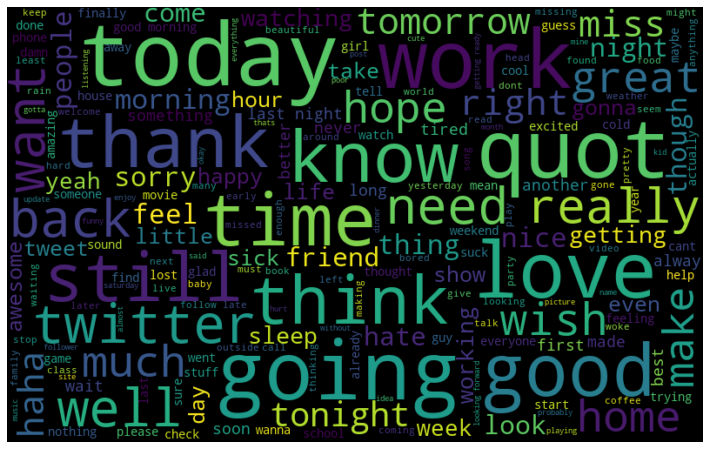

In [23]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in dataset['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

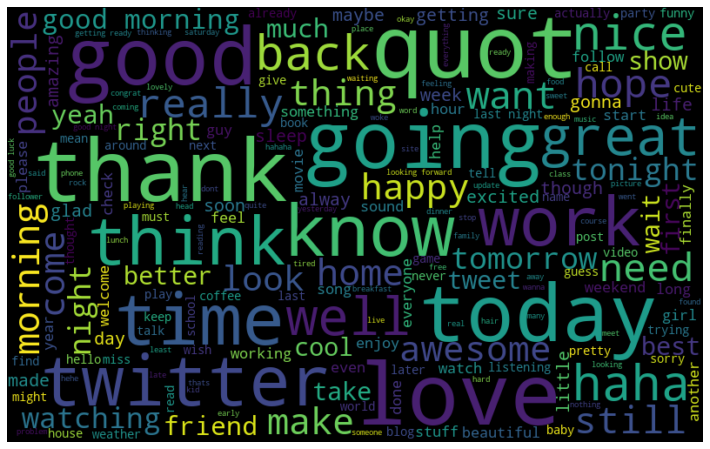

In [24]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

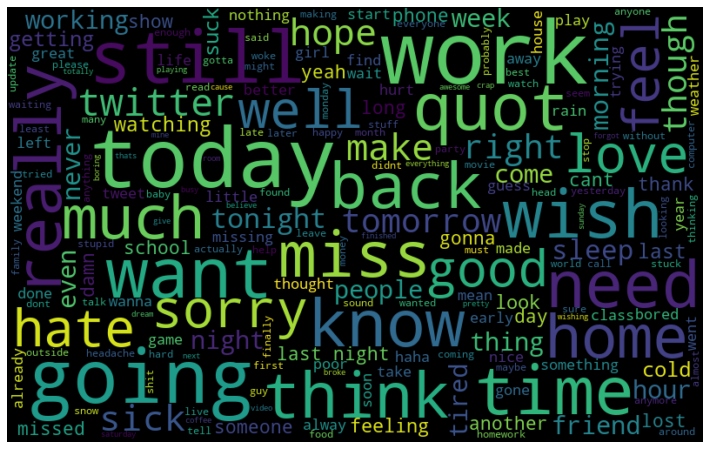

In [25]:
# frequent words visualization for -ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
# Input Feature and Label

X = dataset.text
y = dataset.target

In [27]:
# Splitting our data into Train and Test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [28]:
# Training the Model
# TFIDF : Extracting Tf-idf features

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser. fit(X_train)

print('No. of feature_words: ', len(vectoriser.get_feature_names()))


No. of feature_words:  163546


In [29]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

In [33]:
def model_Evaluate(model):

# Predict values for Test dataset
	y_pred = model.predict(X_test)

# Print the evaluation metrics for the dataset.
	print(classification_report(y_test, y_pred) )

# Compute and plot the Confusion matrix
	cf_matrix_model = confusion_matrix(y_test, y_pred)
	group_names = ['True Neg','False Pos','False Neg','True Pos']
	group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_model.flatten()]
	group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_model.flatten()/np.sum(cf_matrix_model)]
	labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
	labels = np.asarray(labels).reshape(2,2)
	sns.heatmap(cf_matrix_model, annot=labels, fmt='', cmap='binary')

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1000
           1       0.71      0.73      0.72      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



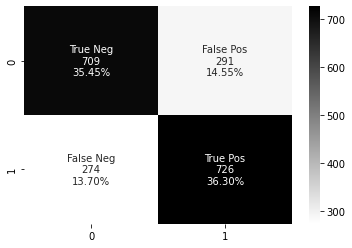

In [34]:
# Model-1 — SVM (Support Vector Machine)
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel. fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred1 = SVCmodel.predict(X_test)



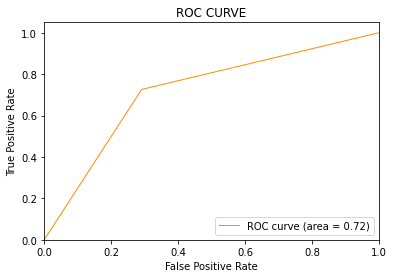

In [35]:
# MODEL —- 1 : ROC — AUC curve - SVM 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1000
           1       0.72      0.74      0.73      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



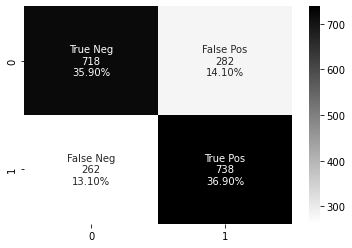

In [36]:
# Model 2 - Logistic Regression
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=~1)
LRmodel. fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred2 = LRmodel.predict(X_test)


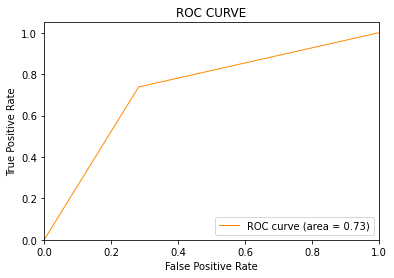

In [37]:
# MODEL —- 2 : ROC — AUC curve - LR classifier
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1000
           1       0.75      0.71      0.73      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



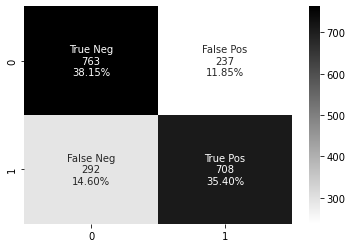

In [38]:
# MODEL - 3 : Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
MNBmodel = MultinomialNB( )
MNBmodel. fit(X_train, y_train)
model_Evaluate(MNBmodel)
y_pred3 = MNBmodel.predict(X_test)

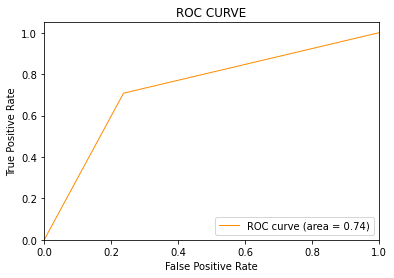

In [39]:
# MODEL —- 3 : ROC — AUC curve - Multinomial Naive Bayes - The higher
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()